# Create Forcing Dataframes for NP Stations

### Variables available:


    II. METEOROLOGICAL DATA    
    (\met\metnp_xx.dat, where xx = NP station number)    
    
    Meteorological data from the 31 North Pole drifting stations    
    combined with the interpolated positions, in 31 files. Most     
    of the observations are every three hours. The missing value     
    flag for all variables is 9999 or 9999.0, depending on     
    whether the variable is stored as an integer or floating     
    point number.     
    
    There are 15 variables in each record:    
    
      Variable             FORTRAN Format    
  --  -------------        --------------    
      1   Station ID                I2        
      2   Year                      I3    
      3   Month                     I3    
      4   Day                       I3    
      5   Time                      I3    
      6   Latitude                  F9.3    
      7   Longitude                 F9.3    
      8   Air temperature           F7.1    
      9   Relative humidity         I5    
      10  Sea level pressure        F7.1    
      11  Wind direction (deg.)     I5    
      12  Wind speed (m/s)          I5    
      13  Total cloudiness          I5    
      14  Low cloudiness            I5    
      15  Surface temperature       I5    

In [2]:
import pandas as pd
import numpy as np
import datetime, pickle
import matplotlib.pyplot as plt
import time
import tqdm
from ll_xy import lonlat_to_xy
import dateutil.parser
import pvlib as pvl
import os
import re
import collections

years = np.arange(3,32,1)
years_dict = [str(c).zfill(2) for c in years]

met_dir = '/home/robbie/Dropbox/Data/W99_raw/MET/'

# Process positions data

In [16]:
pos_names = ['year','month','day','hour','latitude','longitude']

pos_dict = {}
for station_num in tqdm.tqdm(years_dict):
    
    df = pd.read_csv(f'/home/robbie/Dropbox/Data/W99_RAW_BACKUP/W99_raw/POSITION/POSITION.{station_num}',
                     delim_whitespace=True,
                    names=pos_names)
    
    df['Latitude_p'] = [int(str(x)[:2])+float((str(x)[2:]))/1000 if len(str(x))==5 else np.nan for x in df['latitude']]
    df['Longitude_p'] = [int(str(x)[:3])+float((str(x)[3:]))/1000 if len(str(x))==6 else np.nan for x in df['longitude']]
    
    
    idx = np.unique( df.index.values, return_index = True )[1]
    df = df.iloc[idx]
    
    dates = []
    for (y,m,d) in zip(df['year'],df['month'],df['day']):
        try:
            date = datetime.date(y+1900,m,d)
        except:
            date = np.nan
        dates.append(date)
        
    df['Date'] = dates
    
    df['year'] = [1900 + y for y in df['year']]
    
    df.set_index('Date',inplace=True)
    
    pos_dict[station_num] = df

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 200.59it/s]


# Solar

In [27]:
solar = pd.read_csv('/home/robbie/Dropbox/SP_W99_Drifters/Data/W99_clean/SOLAR/DAILYAVG.DAT',
                    delim_whitespace=True,index_col=False,
                    names=['NP','year','month',
                           'day','tempC','RH%',
                           'pressure hPa','wind speed', 
                           'total cloud', 'low cloud',
                           'surface temp','num obs',
                           'latitude','longitude','diffuse radiation',
                           'direct radiation','global radiation',
                           'reflected radiation','albedo','net radiation'])

solar.replace(to_replace=9999,value=np.nan,inplace=True)

solar['date'] = [datetime.date(year=y+1900,month=m,day=d) for (y,m,d) in zip(solar['year'],solar['month'],solar['day'])]

solar['doy'] = [dt.timetuple().tm_yday for dt in solar['date']]

# solar['albedo'] = 100*solar['reflected radiation']/(solar['global radiation']+solar['reflected radiation'])

solar_dict = {}

for NP in set(solar['NP']):
    
    solar_dict[NP] = {}
    
    df = solar[solar['NP']==NP]
    
    years = set(df['year'])
    
    for year in years:
        
        year_df = df[df['year']==year]
        
        year_df.set_index('date',inplace=True)
        
        year_df['zenith']=pvl.solarposition.get_solarposition(year_df.index,
                                           year_df['latitude'],
                                           year_df['longitude'])['zenith']
    
        solar_dict[NP][year] = year_df
        

pickle.dump(solar_dict,open('../../pickles/solar_df','wb'))

/tmp/ipykernel_10780/901470662.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['zenith']=pvl.solarposition.get_solarposition(year_df.index,


In [23]:
year_df.columns

Index(['NP', 'year', 'month', 'day', 'tempC', 'RH%', 'pressure hPa',
       'wind speed', 'total cloud', 'low cloud', 'surface temp', 'num obs',
       'latitude', 'longitude', 'diffuse radiation', 'direct radiation',
       'global radiation', 'reflected radiation', 'albedo', 'net radiation',
       'doy'],
      dtype='object')

In [19]:
solar_dict[17][68]

,NP,year,month,day,tempC,RH%,pressure hPa,wind speed,total cloud,low cloud,...,num obs,latitude,longitude,diffuse radiation,direct radiation,global radiation,reflected radiation,albedo,net radiation,doy
date,,,,,,,,,,,,,,,,,,,,,
1968-05-17,17,68,5,17,-13.1,83.0,1016.2,2,NaN,NaN,...,4,80.975,163.608,NaN,NaN,NaN,NaN,NaN,NaN,138
1968-05-18,17,68,5,18,-16.4,75.0,1021.5,1,NaN,NaN,...,4,81.018,163.520,NaN,NaN,NaN,NaN,NaN,NaN,139
1968-05-19,17,68,5,19,-15.7,77.0,1029.3,1,0.0,0.0,...,4,81.020,163.410,NaN,NaN,NaN,NaN,NaN,NaN,140
1968-05-20,17,68,5,20,-10.2,82.0,1024.3,5,NaN,NaN,...,4,81.087,163.458,NaN,NaN,NaN,NaN,NaN,NaN,141
1968-05-21,17,68,5,21,-4.6,96.0,1011.4,5,10.0,10.0,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968-12-27,17,68,12,27,-44.6,80.0,1033.3,3,0.0,0.0,...,4,87.923,126.118,NaN,NaN,NaN,NaN,NaN,-29.0,362
1968-12-28,17,68,12,28,-41.4,81.0,1032.4,4,2.0,2.0,...,4,87.933,125.242,NaN,NaN,NaN,NaN,NaN,-22.0,363
1968-12-29,17,68,12,29,-29.9,87.0,1022.4,7,NaN,7.0,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364


In [17]:
pos_dict['17']

,year,month,day,hour,latitude,longitude,Latitude_p,Longitude_p
Date,,,,,,,,
1968-05-04,1968,5,4,8,80286,165256,80.286,165.256
1968-05-05,1968,5,5,5,80311,164556,80.311,164.556
1968-05-07,1968,5,7,8,80381,164473,80.381,164.473
1968-05-08,1968,5,8,7,80405,164421,80.405,164.421
1968-05-11,1968,5,11,5,80541,163421,80.541,163.421
...,...,...,...,...,...,...,...,...
1969-10-11,1969,10,11,13,86524,27190,86.524,NaN
1969-10-12,1969,10,12,21,86491,25462,86.491,NaN
1969-10-13,1969,10,13,16,86475,25213,86.475,NaN


# Process the Three Hourly Met Data

In [22]:
met_fields = ['Station ID',
                  "Year",
                  "Month",
                  "Day",
                  "Time",
                  "Latitude",
                  "Longitude",
                  "Air temperature",
                  "Relative humidity",
                  "Sea level pressure",
                  "Wind direction",
                  "Wind speed",
                  "Total cloudiness",
                  "Low cloudiness",
                  "Surface temperature"]

met_dict = {}

for station_num in tqdm.tqdm(years_dict):

    met_data = pd.read_csv(f'{met_dir}METNP_{station_num}.DAT',
                           delim_whitespace=True,
                           index_col=False,
                           names=met_fields)

    met_data.replace([-9.9,-9,9999], np.nan, inplace=True)

    met_data['Year'] = met_data['Year'] + 1900
    
    met_data['date'] = pd.to_datetime(met_data[['Year','Month','Day']])
    
    met_data['x'], met_data['y'] = lonlat_to_xy(np.array(met_data['Longitude']),
                                                np.array(met_data['Latitude']),
                                                hemisphere='n')
    
    fictional_dates = [ind for ind, date in enumerate( met_data['date']) if pd.isnull(date)]

    met_data.drop(fictional_dates,inplace=True)

    hours_list = [datetime.timedelta(hours=x) for x in met_data['Time']]

    met_data['UTC'] = [(x+y)-datetime.timedelta(hours=3) for x, y in zip(met_data['date'],hours_list)]
    
    
    met_data.drop(columns=['date','Month','Year','Day','Time','Station ID'],inplace=True)

    met_data.set_index(['UTC'],inplace=True,drop=True)
    
    diff = met_data.shape[0] - np.count_nonzero(np.nan_to_num(met_data['Longitude']))
    if diff>0:
        positions = pos_dict[station_num]
        df_no_loc = met_data[np.isnan(met_data['Longitude'])]
        for dt in df_no_loc.index:
            date = dt.date()
            position = positions[positions['Date']==date]
            lon, lat = position['Longitude_p'], position['Latitude_p']
            met_data.loc[dt]['Longitude'] = lon
            met_data.loc[dt]['Longitude'] = lat
        diff = met_data.shape[0] - np.count_nonzero(np.nan_to_num(met_data['Longitude']))
        
    

    met_data['zenith']=pvl.solarposition.get_solarposition(met_data.index,
                                           met_data['Latitude'],
                                           met_data['Longitude'])['zenith']

    
    met_dict[station_num] = met_data

100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


In [4]:
pickle.dump(met_dict, open('met_dict.p', 'wb'))

/tmp/ipykernel_16600/249024296.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['UTC'] = [datetime.datetime(d.year,d.month,d.day,h) for d,h in zip(p['Date'],p['hour'])]


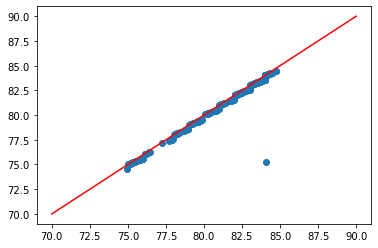

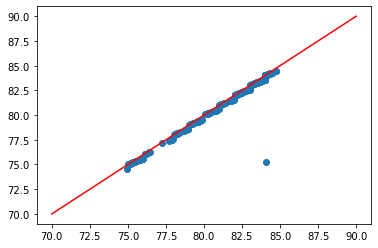

In [34]:
m.shape, p.shape

((24059, 13), (1269, 9))